In [ ]:
import os

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 62.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=471884b54441d2b745b9087d5c3f5e79cfaa9ea4f2f3392103ef392d273c9d45
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 40 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Rea

In [ ]:
import os
import pandas as pd

import pyspark

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cur_path = "/content/drive/MyDrive/Colab Notebooks/Big-data-scaling-team-project-group2/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/Colab Notebooks/Big-data-scaling-team-project-group2


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('final').getOrCreate()

In [ ]:
data = spark.read.csv('data/cleaned_data.csv',inferSchema=True,header=True)

scatter plot

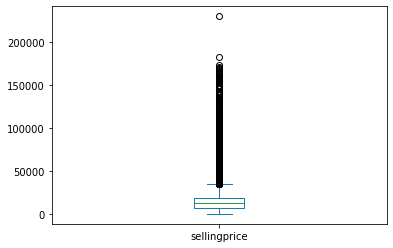

In [ ]:
data.select(["sellingprice"]).toPandas().plot.box()

In [ ]:
data=data.withColumn('price_gap', ( data['sellingprice'] - data['mmr'] ))
data=data.filter(data.price_gap<500).filter(data.price_gap>-500)
data=data.filter(data.sellingprice<5000).filter(data.sellingprice>800)

model

In [ ]:
data=data.withColumn("used_year",data["saledate"]-data["year"])
data.sort(["price_gap"]).show()

+------+----+----------+----------------+------+---------+------------+-----+---------+--------+------+--------+--------------------+----+------------+--------+----------+---------+---------+
|   _c0|year|      make|           model|  trim|     body|transmission|state|condition|odometer| color|interior|              seller| mmr|sellingprice|saledate|madeRegion|price_gap|used_year|
+------+----+----------+----------------+------+---------+------------+-----+---------+--------+------+--------+--------------------+----+------------+--------+----------+---------+---------+
|303072|2010|    Nissan|           Versa| 1.8 S|hatchback|   automatic|   ca|      1.9|156435.0| white|    gray|nissan motor acce...|3475|        3000|    2015|        3n|     -475|        5|
|316321|2003|     Honda|           Civic|    EX|    coupe|   automatic|   ga|      2.7|155027.0|  gray|   beige|mid atlantic fina...|2675|        2200|    2015|        1h|     -475|       12|
|303847|2007|    Nissan|          Altima

In [ ]:
data.cache()
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: integer (nullable = true)
 |-- madeRegion: string (nullable = true)
 |-- price_gap: integer (nullable = true)
 |-- used_year: integer (nullable = true)



- Create a model to predict selling prices for cars. We will split data, create a few models using 
MLlib, and then compare their accuracy. When we handle modeling, we will use a data pipeline 
from Spark. 
 


In [ ]:
from pyspark.ml import Pipeline

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

In [ ]:
# pipelines:
make_stringIndexer_l=StringIndexer(inputCol="make", outputCol="makeIndex")
model_stringIndexer_l=StringIndexer(inputCol="model", outputCol="modelIndex")
trim_stringIndexer_l=StringIndexer(inputCol="trim", outputCol="trimIndex")
body_stringIndexer_l=StringIndexer(inputCol="body", outputCol="bodyIndex")
transmission_stringIndexer_l=StringIndexer(inputCol="transmission", outputCol="transmissionIndex")

make_hotEncoder=OneHotEncoder(inputCol="makeIndex", outputCol="makeVector")
model_hotEncoder=OneHotEncoder(inputCol="modelIndex", outputCol="modelVector")
trim_hotEncoder=OneHotEncoder(inputCol="trimIndex", outputCol="trimVector")
body_hotEncoder=OneHotEncoder(inputCol="bodyIndex", outputCol="bodyVector")
transmission_hotEncoder=OneHotEncoder(inputCol="transmissionIndex", outputCol="transmissionVector")

#assembler = VectorAssembler(inputCols=["used_year","makeVector","modelVector","trimVector","bodyVector","transmissionVector","condition","odometer","mmr","saledate"],outputCol='features')
#assembler = VectorAssembler(inputCols=["used_year","makeVector","modelVector","trimVector","bodyVector","transmissionVector","condition","odometer","mmr","saledate"],outputCol='features')
#assembler = VectorAssembler(inputCols=["mmr"],outputCol='features')
#normalizer = Normalizer(inputCol="unNorm_features", outputCol="features", p=1.0)
#assembler = VectorAssembler(inputCols=["used_year","condition","odometer","mmr"],outputCol='features')
assembler = VectorAssembler(inputCols=["used_year","condition","odometer","mmr"],outputCol='features')

pipeline = Pipeline(stages=[make_stringIndexer_l, model_stringIndexer_l,trim_stringIndexer_l,body_stringIndexer_l,transmission_stringIndexer_l,make_hotEncoder,model_hotEncoder,trim_hotEncoder,body_hotEncoder,transmission_hotEncoder,assembler])
#pipeline = Pipeline(stages=[assembler])

model=pipeline.fit(data)
clean_data=model.transform(data)
prepare_data=clean_data.select(["features","sellingprice"])

In [ ]:
prepare_data.show()

+--------------------+------------+
|            features|sellingprice|
+--------------------+------------+
|[2.0,3.0,149962.0...|        3200|
|[3.0,3.4365174321...|        2350|
|[4.0,3.4365174321...|        2700|
|[4.0,3.6,134319.0...|        4500|
|[4.0,3.4365174321...|        3100|
|[4.0,3.4365174321...|        4700|
|[4.0,2.0,52373.0,...|        3600|
|[5.0,2.6,123631.0...|        3600|
|[5.0,2.1,147998.0...|        4300|
|[5.0,2.7,127609.0...|        4500|
|[5.0,3.8,139959.0...|        3600|
|[5.0,3.8,106090.0...|        3700|
|[5.0,3.4,76092.0,...|        3900|
|[5.0,1.9,99593.0,...|        4800|
|[6.0,3.5,132932.0...|        4000|
|[6.0,2.9,112455.0...|        3900|
|[6.0,2.4,102192.0...|        2900|
|[6.0,1.9,170680.0...|        3000|
|[6.0,2.1,135414.0...|        3700|
|[7.0,2.6,198177.0...|        2000|
+--------------------+------------+
only showing top 20 rows



split train test

In [ ]:
train, test = prepare_data.randomSplit([0.7, 0.3])

In [ ]:
test.show()

+--------------------+------------+
|            features|sellingprice|
+--------------------+------------+
|[3.0,1.9,96191.0,...|        4600|
|[3.0,2.0,101619.0...|        2800|
|[3.0,2.0,106943.0...|        3700|
|[3.0,2.5,180926.0...|        3500|
|[3.0,3.0,130802.0...|        4750|
|[3.0,3.4365174321...|        4800|
|[3.0,3.4365174321...|        2350|
|[4.0,1.9,59795.0,...|        4500|
|[4.0,1.9,91334.0,...|        4500|
|[4.0,1.9,98562.0,...|        4900|
|[4.0,1.9,100227.0...|        4000|
|[4.0,1.9,122266.0...|        3700|
|[4.0,1.9,152983.0...|        2900|
|[4.0,1.9,205326.0...|        4950|
|[4.0,2.0,79200.0,...|        4500|
|[4.0,2.0,131622.0...|        3300|
|[4.0,2.0,227397.0...|        4600|
|[4.0,2.1,81183.0,...|        4900|
|[4.0,2.1,138510.0...|        3700|
|[4.0,2.1,155742.0...|        3200|
+--------------------+------------+
only showing top 20 rows



linear regression

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
lr = LinearRegression(featuresCol='features',labelCol='sellingprice')
lrModel=lr.fit(prepare_data)

In [ ]:
trainingSummaryLr=lrModel.summary
trainingSummaryLr.predictions.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|[2.0,3.0,149962.0...|      3200.0|3602.4252636974616|
|[3.0,3.4365174321...|      2350.0|2658.6097202959536|
|[4.0,3.4365174321...|      2700.0|2862.9014309636386|
|[4.0,3.6,134319.0...|      4500.0| 4065.910221321642|
|[4.0,3.4365174321...|      3100.0| 3091.931654865367|
|[4.0,3.4365174321...|      4700.0| 4863.593087798013|
|[4.0,2.0,52373.0,...|      3600.0| 3468.883154801191|
|[5.0,2.6,123631.0...|      3600.0|3224.9531551783807|
|[5.0,2.1,147998.0...|      4300.0| 4134.794076211457|
|[5.0,2.7,127609.0...|      4500.0| 4617.713496668631|
|[5.0,3.8,139959.0...|      3600.0| 3313.813441469631|
|[5.0,3.8,106090.0...|      3700.0| 3476.567748858359|
|[5.0,3.4,76092.0,...|      3900.0| 3666.776613429498|
|[5.0,1.9,99593.0,...|      4800.0|4476.4139000719415|
|[6.0,3.5,132932.0...|      4000.0|3753.4462569892617|
|[6.0,2.9,

evaluate

In [ ]:
test_results = lrModel.evaluate(test)

In [ ]:
print("RMSE: {}".format(test_results.r2))

RMSE: 0.949006800804235


In [ ]:
test_results.residuals.show()
print("RMSE: {}".format(test_results.rootMeanSquaredError))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------------------+
|          residuals|
+-------------------+
|-159.08225503984522|
| -291.0990012085372|
|   177.726457254028|
| 228.42324122376567|
|-310.44453922859157|
|  77.68998261170964|
| -308.6097202959536|
|-232.09581079741656|
|  457.0772251280623|
| 210.41927942991788|
|-20.227746049435154|
|   513.728717753153|
| -266.5667347609474|
|-160.74168839217418|
| -72.58531673566813|
|-60.174364373262506|
| 317.98461597569167|
| 11.040232992868368|
|-335.92510699199556|
| 166.08532769705153|
+-------------------+
only showing top 20 rows

RMSE: 265.00458113075246


Decision Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
dt=DecisionTreeRegressor(labelCol="sellingprice", featuresCol="features")
dtModel=dt.fit(prepare_data)

predict

In [ ]:
predictions_dt = dtModel.transform(train)

In [ ]:
predictions_dt.select("prediction", "sellingprice", "features").show()

+------------------+------------+--------------------+
|        prediction|sellingprice|            features|
+------------------+------------+--------------------+
|3624.1621376811595|        3200|[2.0,3.0,149962.0...|
| 3909.953703703704|        3800|[2.0,3.4,105858.0...|
| 4073.936170212766|        3800|[3.0,1.0,114632.0...|
| 4327.352437981181|        4000|[3.0,1.7,71048.0,...|
| 4467.609915809167|        4900|[3.0,1.9,55671.0,...|
| 4327.352437981181|        4500|[3.0,1.9,63905.0,...|
| 4467.609915809167|        4200|[3.0,1.9,78340.0,...|
| 4733.625730994152|        4700|[3.0,1.9,86299.0,...|
| 4327.352437981181|        3900|[3.0,1.9,99353.0,...|
| 4733.625730994152|        4700|[3.0,2.0,91867.0,...|
| 4733.625730994152|        4900|[3.0,2.1,84746.0,...|
|3201.9980694980695|        3500|[3.0,2.3,98272.0,...|
| 4585.408057851239|        4500|[3.0,2.4,66206.0,...|
| 4733.625730994152|        4600|[3.0,2.5,79456.0,...|
|3754.2994071146245|        3700|[3.0,2.6,114697.0...|
| 4585.408

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_dt)
print ("Root Mean Squared Error (RMSE) on test data ="+ str(rmse))

Root Mean Squared Error (RMSE) on test data =261.43015749147867


Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
rf_m = RandomForestRegressor(featuresCol="features",labelCol="sellingprice")

In [ ]:
rf_model = rf_m.fit(prepare_data)

In [ ]:
predictions = rf_model.transform(test)

# Select example rows to display.
predictions.select("prediction", "sellingprice", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+------------------+------------+--------------------+
|        prediction|sellingprice|            features|
+------------------+------------+--------------------+
| 4535.275603283461|        4600|[3.0,1.9,96191.0,...|
| 3339.815190808411|        2800|[3.0,2.0,101619.0...|
|3707.9083049109868|        3700|[3.0,2.0,106943.0...|
|3365.2944222514707|        3500|[3.0,2.5,180926.0...|
| 4465.371307048614|        4750|[3.0,3.0,130802.0...|
+------------------+------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 301.785


Correlation

In [ ]:
from pyspark.sql.functions import corr

In [ ]:
data.show()

+----+----+---------+----------+--------+---------+------------+-----+------------------+--------+------+--------+--------------------+----+------------+--------+----------+---------+---------+
| _c0|year|     make|     model|    trim|     body|transmission|state|         condition|odometer| color|interior|              seller| mmr|sellingprice|saledate|madeRegion|price_gap|used_year|
+----+----+---------+----------+--------+---------+------------+-----+------------------+--------+------+--------+--------------------+----+------------+--------+----------+---------+---------+
| 979|2012|     Ford|    Fiesta|       S|    sedan|   automatic|   ca|               3.0|149962.0| white|    gray|enterprise fm exc...|3650|        3200|    2014|        3f|     -450|        2|
|1998|2011|Chevrolet|       HHR|Panel LS|    wagon|   automatic|   ca|3.4365174321136176|236928.0| white|   black| north star auto inc|2625|        2350|    2014|        3g|     -275|        3|
|2438|2010|Chevrolet|      Ave

In [ ]:
data.select(corr('used_year','sellingprice')).show()

+-----------------------------+
|corr(used_year, sellingprice)|
+-----------------------------+
|          -0.5566397537089032|
+-----------------------------+



In [ ]:
pipeline2 = Pipeline(stages=[make_stringIndexer_l, model_stringIndexer_l,trim_stringIndexer_l,body_stringIndexer_l,transmission_stringIndexer_l,make_hotEncoder,model_hotEncoder,trim_hotEncoder,body_hotEncoder,transmission_hotEncoder])

In [ ]:
Model2=pipeline2.fit(data)
data2=Model2.transform(data)
data2.show()

+----+----+---------+----------+--------+---------+------------+-----+------------------+--------+------+--------+--------------------+----+------------+--------+----------+---------+---------+---------+----------+---------+---------+-----------------+---------------+-----------------+-----------------+-------------+------------------+
| _c0|year|     make|     model|    trim|     body|transmission|state|         condition|odometer| color|interior|              seller| mmr|sellingprice|saledate|madeRegion|price_gap|used_year|makeIndex|modelIndex|trimIndex|bodyIndex|transmissionIndex|     makeVector|      modelVector|       trimVector|   bodyVector|transmissionVector|
+----+----+---------+----------+--------+---------+------------+-----+------------------+--------+------+--------+--------------------+----+------------+--------+----------+---------+---------+---------+----------+---------+---------+-----------------+---------------+-----------------+-----------------+-------------+------

In [ ]:
#"modelVector","trimVector","bodyVector","transmissionVector","condition","odometer","mmr","saledate"
data2.select(corr('used_year','sellingprice')).show()
data2.select(corr('makeIndex','sellingprice')).show()
data2.select(corr('modelIndex','sellingprice')).show()
data2.select(corr('trimIndex','sellingprice')).show()
data2.select(corr('bodyIndex','sellingprice')).show()
data2.select(corr('transmissionIndex','sellingprice')).show()
data2.select(corr('condition','sellingprice')).show()
data2.select(corr('odometer','sellingprice')).show()
data2.select(corr('mmr','sellingprice')).show()
data2.select(corr('saledate','sellingprice')).show()

+-----------------------------+
|corr(used_year, sellingprice)|
+-----------------------------+
|          -0.5566397537089032|
+-----------------------------+

+-----------------------------+
|corr(makeIndex, sellingprice)|
+-----------------------------+
|         -0.01058001766845...|
+-----------------------------+

+------------------------------+
|corr(modelIndex, sellingprice)|
+------------------------------+
|           0.01157341414867422|
+------------------------------+

+-----------------------------+
|corr(trimIndex, sellingprice)|
+-----------------------------+
|         0.011571672734873722|
+-----------------------------+

+-----------------------------+
|corr(bodyIndex, sellingprice)|
+-----------------------------+
|         0.034276805172843657|
+-----------------------------+

+-------------------------------------+
|corr(transmissionIndex, sellingprice)|
+-------------------------------------+
|                 -0.03059604355275076|
+-----------------------------

In [ ]:
for i in range(0, 30):
  dt=DecisionTreeRegressor(labelCol="sellingprice", featuresCol="features", maxDepth=i)
  dtModel=dt.fit(train)
  predictions_dt = dtModel.transform(test)

  evaluator = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predictions_dt)
  print ("Root Mean Squared Error (RMSE) on test data ="+ str(rmse)+" i is "+ str(i))

Root Mean Squared Error (RMSE) on test data =1173.5452247211238 i is 0
Root Mean Squared Error (RMSE) on test data =619.464359982723 i is 1
Root Mean Squared Error (RMSE) on test data =378.36634978320177 i is 2
Root Mean Squared Error (RMSE) on test data =293.69868154384903 i is 3
Root Mean Squared Error (RMSE) on test data =268.8156626514373 i is 4
Root Mean Squared Error (RMSE) on test data =261.77460306138164 i is 5
Root Mean Squared Error (RMSE) on test data =261.0095246933187 i is 6
Root Mean Squared Error (RMSE) on test data =261.63755558649893 i is 7
Root Mean Squared Error (RMSE) on test data =263.81405602518254 i is 8
Root Mean Squared Error (RMSE) on test data =267.3392284323777 i is 9
Root Mean Squared Error (RMSE) on test data =271.7921288092385 i is 10
Root Mean Squared Error (RMSE) on test data =277.49237295881574 i is 11
Root Mean Squared Error (RMSE) on test data =285.6706608199537 i is 12
Root Mean Squared Error (RMSE) on test data =294.1063493624309 i is 13
Root Mean 

- Find important factors to predict the car price. After selecting the final model having the highest 
accuracy, we will explore the importance of each attribute by using Spark.

In [ ]:
dtModel.featureImportances

SparseVector(4, {1: 0.0, 3: 1.0})

In [ ]:
print("Coefficients: {}".format(str(lrModel.coefficients))) # For each feature...
print(len(lrModel.coefficients))
print('\n')
print("Intercept:{}".format(str(lrModel.intercept)))

Coefficients: [1.9144088677132771,52.25774564727956,0.00013702718734436259,0.956544463982252]
4


Intercept:-70.1129555835589


In [ ]:
display(dtModel) #visualize the decision tree model
print(dtModel.toDebugString) #print the nodes of the decision tree model


DecisionTreeRegressionModel: uid=DecisionTreeRegressor_86e55e23ab4b, depth=5, numNodes=63, numFeatures=4

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_86e55e23ab4b, depth=5, numNodes=63, numFeatures=4
  If (feature 3 <= 2762.5)
   If (feature 3 <= 1787.5)
    If (feature 3 <= 1387.5)
     If (feature 3 <= 1062.5)
      If (feature 3 <= 862.5)
       Predict: 999.7317813765183
      Else (feature 3 > 862.5)
       Predict: 1117.107465135357
     Else (feature 3 > 1062.5)
      If (feature 3 <= 1287.5)
       Predict: 1216.3954044997606
      Else (feature 3 > 1287.5)
       Predict: 1307.3364485981308
    Else (feature 3 > 1387.5)
     If (feature 3 <= 1587.5)
      If (feature 3 <= 1487.5)
       Predict: 1405.8061420345489
      Else (feature 3 > 1487.5)
       Predict: 1511.4496197718631
     Else (feature 3 > 1587.5)
      If (feature 3 <= 1687.5)
       Predict: 1603.4422110552764
      Else (feature 3 > 1687.5)
       Predict: 1711.4057672502574
   Else (feature 3 > 1787.5)
    If (feature 3 <= 2237.5)
     If (feature 3 <= 2012.5)
      If (feature 3 <= 1912.5)
       Predi

In [ ]:
list(zip(assembler.getInputCols(), dtModel.featureImportances))

[('used_year', 0.0),
 ('condition', 4.8742836110650505e-05),
 ('odometer', 0.0),
 ('mmr', 0.9999512571638893)]